# Before you start: 

This HW is different from the previous ones, that it allows you to choose your own datasets and model sizes. Hence answers may not be fixed, if you found any results ambiguous or not sufficiently good, then make your best guess. 

- If the data you choose is too big, you can use a part of the dataset and/or run the notebook in Google Colaboratory. 
- You may use CPU or GPU to train the data. 
- Allow sufficient time for training as it may take times. 
- If your notebook takes >= 2 days to run entirely, you might be using the wrong data scale or model scale or your code is not efficient in some sense. 

Finally, **make sure to run the entire notebook and all results are visible before you submit the file**. If not, you may get a penalty. 

# Fully Connected Network Exercise

Maximum Number of points: 56 pts

Data Analysis: 20 pts 

Data Loader: 12 pts

Model Training, Testing, Results Interpretations: 24 pts

**For this exercise, you will pick one dataset from the following list of datasets in Seaborn package, to perform REGRESSION Task.**

anagrams

anscombe

attention

brain_networks

car_crashes

planets

taxis

flights

fmri

tips

titanic

diamonds

dots

dowjones

healthexp

exercise

geyser

seaice

penguins

glue

mpg

Note: To encourage diversity, members of the same final project group must select different datasets for their submissions. Please communicate with your teammates to make sure there is no overlap.


**Import usual libraries you would use.**

In [5]:
import os, random, math, json, time
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

SEED = 42
def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False
set_seed()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cpu


**1. What is the dataset you choose?** 

In [41]:
dataset_name = "penguins"
print("Chosen dataset:", dataset_name)

Chosen dataset: penguins


**2. Write a short paragraph to describe the features of the dataset. (This info can be found online).**

In [ ]:
# The Palmer Penguins dataset is a biological dataset collected from the Palmer Archipelago in Antarctica by Dr. Kristen Gorman and the Palmer Station LTER. It contains measurements for 345 penguins from three species—Adelie, Chinstrap, and Gentoo—across three islands (Biscoe, Dream, and Torgersen). For each penguin, the dataset records bill length, bill depth, flipper length, body mass, sex, and the island of origin, along with the species label.

**3. What is your input and target features for regression? (You may refer to the dataset description to find the usual tasks needed to perform on this dataset. Also you can do data manipulations).**

In [10]:
# In this project, I'll treat body mass (in grams) as the target feature for a regression task, since it is a continuous variable that can be predicted from other measurable characteristics of each penguin. The input features (predictors) are the remaining numeric and categorical attributes that describe the penguin’s morphology and habitat: bill length (mm), bill depth (mm), flipper length (mm), island, and sex. These variables provide biologically meaningful information that influences a penguin’s body mass. By using these as inputs and body mass as the target, the model can learn relationships such as how body size varies across species, sexes, and islands.


**4. Import the data from seaborn and check the head of the dataframe.**

In [9]:
# WRITE YOUR ANSWER HERE

In [11]:
penguins = sns.load_dataset("penguins")
print("Shape of dataset:", penguins.shape)
penguins.head()

Shape of dataset: (344, 7)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


# Explore the data

**In this section, show at least three plots to explore the data and summarize what you see.**

E.g. the plots can be: 
histogram, 
pairplot, 
countplot,
jointplot,
heatmap,
linear model plot,
kde distribution

Alternatively, you can replace one plot by data transformation e.g. categorical data to numbers or other types of data manipulation.

**5. Plot 1**

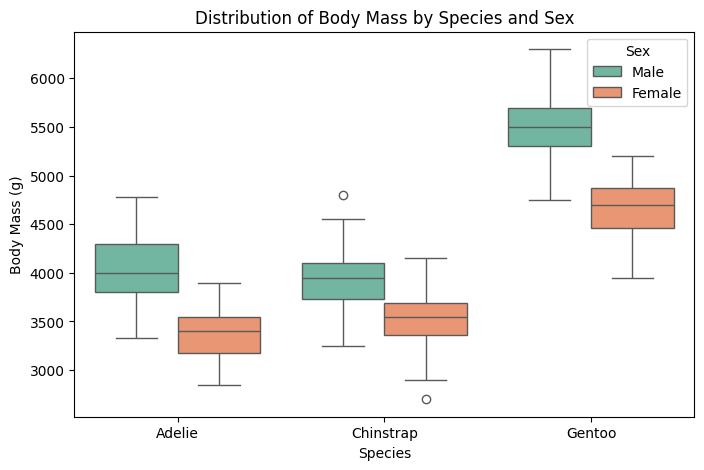

In [12]:
plt.figure(figsize=(8,5))
sns.boxplot(data=penguins, x="species", y="body_mass_g", hue="sex", palette="Set2")
plt.title("Distribution of Body Mass by Species and Sex")
plt.ylabel("Body Mass (g)")
plt.xlabel("Species")
plt.legend(title="Sex")
plt.show()

**6. Summary the insights you see from this plot in 1-3 sentences.**

In [ ]:
# This plot shows that Gentoo penguins are the heaviest, followed by Adelie and Chinstrap species.
# Across all species, males have higher body mass than females, indicating sexual dimorphism.
# The spread of body mass is also largest for Gentoo penguins, suggesting greater size variation within that species.

**7. Plot 2**

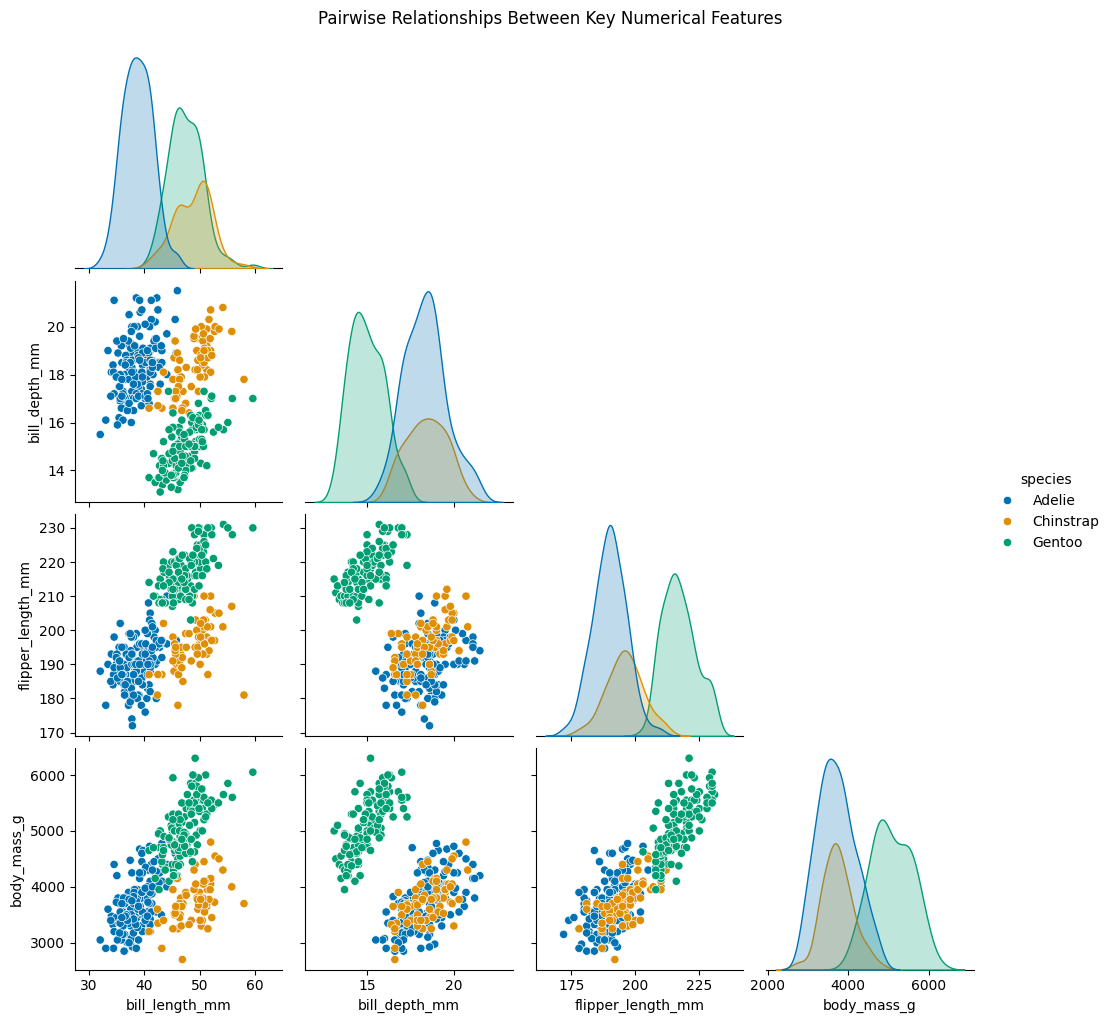

In [13]:
sns.pairplot(
    penguins,
    vars=["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"],
    hue="species",
    palette="colorblind",
    corner=True
)
plt.suptitle("Pairwise Relationships Between Key Numerical Features", y=1.02)
plt.show()


**8. Summary the insights you see from this plot in 1-3 sentences.**

In [ ]:
# Gentoo penguins generally have longer flippers and higher body mass, while Adelie penguins are smaller with shorter bills and flippers.
# The positive relationships between features like flipper length and body mass suggest that larger body size correlates with longer appendages.

**9. Plot 3**

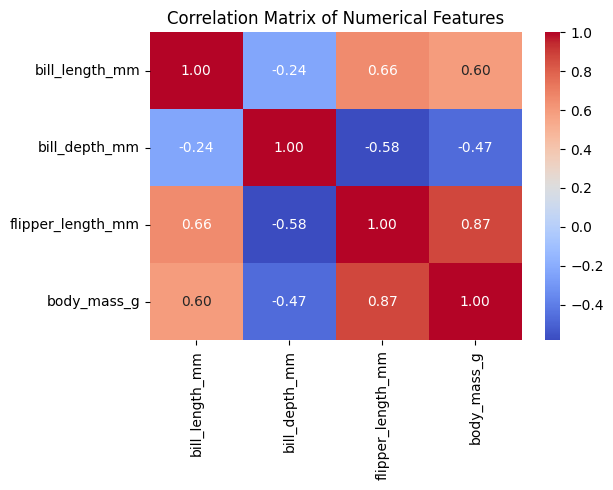

In [14]:
plt.figure(figsize=(6,4))
sns.heatmap(
    penguins[["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]].corr(),
    annot=True, cmap="coolwarm", fmt=".2f"
)
plt.title("Correlation Matrix of Numerical Features")
plt.show()


**10. Summary the insights you see from this plot in 1-3 sentences.**

In [ ]:
# The heatmap indicates that flipper length and body mass are strongly positively correlated (r ≈ 0.87), making flipper length a strong predictor of body mass.
# Bill length also shows moderate positive correlation with body mass, while bill depth has a weaker, slightly negative relationship.
# Overall, the correlations confirm that physical dimensions, especially flipper length, are key drivers of variation in penguin body size.

**(Alternatively) 9-10. Data Transformation/Manipulation (not including scaling).**

In [ ]:
# WRITE YOUR ANSWER HERE

# Load the dataset in PyTorch 

**11-13. In this question, you need to create the dataloader for your seaborn dataset. (6 pts)**

Tip: This can be done using either way: 

1. Reading dataframe file from seaborn library, convert it to PyTorch tensor and create dataloaders.
2. Download a csv from the seaborn github, using that csv in creating PyTorch dataloaders. (https://github.com/mwaskom/seaborn-data)

In [24]:
df = sns.load_dataset("penguins").dropna()
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (333, 7)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [25]:
target_col = "body_mass_g"
X = df.drop(columns=[target_col])
y = df[target_col].values

# Convert categorical columns to numeric form
X = pd.get_dummies(X, drop_first=True)

# Standardize numeric columns for better training stability
scaler = StandardScaler()
X[X.columns] = scaler.fit_transform(X)

print("Feature matrix shape:", X.shape)
X.head()

Feature matrix shape: (333, 8)


,bill_length_mm,bill_depth_mm,flipper_length_mm,species_Chinstrap,species_Gentoo,island_Dream,island_Torgersen,sex_Male
0,-0.896042,0.780732,-1.426752,-0.506561,-0.745704,-0.76532,2.466801,0.991031
1,-0.822788,0.119584,-1.069474,-0.506561,-0.745704,-0.76532,2.466801,-1.009050
2,-0.676280,0.424729,-0.426373,-0.506561,-0.745704,-0.76532,2.466801,-1.009050
4,-1.335566,1.085877,-0.569284,-0.506561,-0.745704,-0.76532,2.466801,-1.009050
5,-0.859415,1.747026,-0.783651,-0.506561,-0.745704,-0.76532,2.466801,0.991031


In [26]:
class PenguinsDataset(Dataset):
    def __init__(self, features, targets):
        self.X = torch.tensor(features.values, dtype=torch.float32)
        self.y = torch.tensor(targets, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create the full dataset
full_dataset = PenguinsDataset(X, y)
print(f"Full dataset created with {len(full_dataset)} samples.")

Full dataset created with 333 samples.


**14. Check: Make sure you scaled/ normalized the dataset.**

In [27]:
sample_X, sample_y = full_dataset[0]
print("Sample feature shape:", sample_X.shape)
print("Sample target:", sample_y)

Sample feature shape: torch.Size([8])
Sample target: tensor([3750.])


## Training set and testing set.

**15. Split the data into a training set and a testing set using 30% test size.**

Tip: Use torch.utils.data.random_split to divide the full_dataset into the specified sizes.

In [28]:
from torch.utils.data import random_split

# Define sizes
total_size = len(full_dataset)
test_size = int(0.3 * total_size)
train_size = total_size - test_size

# Split into training and testing sets
train_dataset, test_dataset = random_split(
    full_dataset, [train_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

Training samples: 234
Testing samples: 99


**16. Your dataloader should looks like this. Choose a batch size here.**

In [29]:
from torch.utils.data import DataLoader

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

for X_batch, y_batch in train_dataloader:
    print("Feature batch shape:", X_batch.shape)
    print("Target batch shape:", y_batch.shape)
    break

Feature batch shape: torch.Size([16, 8])
Target batch shape: torch.Size([16, 1])


## Create a Fully Connected Neural Networks

**17-19. Your network should have at least 3 layers. Feel free to choose the number of nodes in each layer. (6 pts)** 

In [30]:
import torch.nn as nn
import torch.nn.functional as F

# Defining a Fully Connected Neural Network for regression
class FCNeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden1=64, hidden2=32, hidden3=16, output_dim=1):
        super(FCNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.fc4 = nn.Linear(hidden3, output_dim)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # regression output, no activation
        return x

# Initializing model
input_dim = X.shape[1]
model = FCNeuralNetwork(input_dim=input_dim)
print(model)


FCNeuralNetwork(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


**20. Define the loss function & optimizer**

In [31]:
import torch.nn as nn
from torch.optim import Adam

# Mean Squared Error is ideal for regression
criterion = nn.MSELoss()

# Adam optimizer for efficient training
optimizer = Adam(model.parameters(), lr=0.001)

# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Using device:", device)

Using device: cpu


**21-23. Fit the FCNN model to the training data. (6 pts)**

Epoch [10/100] - Train Loss: 16992771.1333, Test Loss: 15865050.2857
Epoch [20/100] - Train Loss: 2028671.1917, Test Loss: 1913475.2991
Epoch [30/100] - Train Loss: 609609.9625, Test Loss: 425478.4241
Epoch [40/100] - Train Loss: 602258.3854, Test Loss: 286562.8438
Epoch [50/100] - Train Loss: 493477.1208, Test Loss: 234186.2656
Epoch [60/100] - Train Loss: 502750.3563, Test Loss: 209612.8917
Epoch [70/100] - Train Loss: 500974.0646, Test Loss: 229349.2835
Epoch [80/100] - Train Loss: 485382.6406, Test Loss: 193730.1027
Epoch [90/100] - Train Loss: 383725.4760, Test Loss: 151991.1646
Epoch [100/100] - Train Loss: 404810.1531, Test Loss: 154319.3728


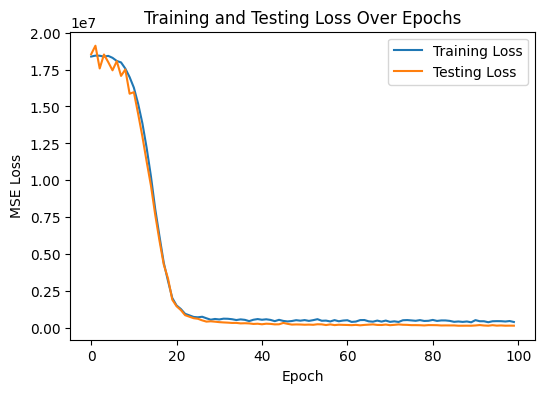

In [33]:
import matplotlib.pyplot as plt

num_epochs = 100
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # ---- Training Phase ----
    model.train()
    running_loss = 0.0
    for Xb, yb in train_dataloader:
        Xb, yb = Xb.to(device), yb.to(device)
        
        # Forward pass
        preds = model(Xb)
        loss = criterion(preds, yb)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_dataloader)
    train_losses.append(train_loss)
    
    # ---- Evaluation Phase ----
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for Xb, yb in test_dataloader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            test_loss += criterion(preds, yb).item()
        test_loss /= len(test_dataloader)
        test_losses.append(test_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

# ---- Plot Loss Curves ----
plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.show()


## Predict and Evaluate

**24. Predict values using the model and test data.**

In [34]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for Xb, yb in test_dataloader:
        Xb = Xb.to(device)
        preds = model(Xb).cpu().numpy().flatten()
        y_pred.extend(preds)
        y_true.extend(yb.numpy().flatten())

# Display first few predictions
for i in range(5):
    print(f"Actual: {y_true[i]:.1f} | Predicted: {y_pred[i]:.1f}")


Actual: 5300.0 | Predicted: 5463.8
Actual: 4675.0 | Predicted: 4093.8
Actual: 3700.0 | Predicted: 2834.7
Actual: 2925.0 | Predicted: 3242.9
Actual: 4775.0 | Predicted: 3768.6


**25. Compute the error on the test data**

In [35]:
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.3f}")


Mean Absolute Error (MAE): 317.10
R² Score: 0.692


**26-27. Build a linear regression model in PyTorch and train it on train data. Compute the LR error on the test data. (4 pts)**

In [36]:
import torch.nn as nn
from torch.optim import SGD
from sklearn.metrics import mean_absolute_error, r2_score

# Defining a simple linear regression model (no hidden layers)
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

# Initialize model
lr_model = LinearRegressionModel(input_dim=X.shape[1])
lr_model.to(device)

# Define loss and optimizer (use same criterion for fair comparison)
criterion_lr = nn.MSELoss()
optimizer_lr = SGD(lr_model.parameters(), lr=0.01)

# Training loop
epochs = 100
train_losses_lr, test_losses_lr = [], []

for epoch in range(epochs):
    # Training phase
    lr_model.train()
    running_loss = 0.0
    for Xb, yb in train_dataloader:
        Xb, yb = Xb.to(device), yb.to(device)
        preds = lr_model(Xb)
        loss = criterion_lr(preds, yb)
        optimizer_lr.zero_grad()
        loss.backward()
        optimizer_lr.step()
        running_loss += loss.item()
    train_losses_lr.append(running_loss / len(train_dataloader))

    # Testing phase
    lr_model.eval()
    with torch.no_grad():
        total_loss = 0.0
        for Xb, yb in test_dataloader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = lr_model(Xb)
            total_loss += criterion_lr(preds, yb).item()
        test_losses_lr.append(total_loss / len(test_dataloader))
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses_lr[-1]:.4f} | Test Loss: {test_losses_lr[-1]:.4f}")

# Evaluate the Linear Regression model on the test data
lr_model.eval()
y_true_lr, y_pred_lr = [], []
with torch.no_grad():
    for Xb, yb in test_dataloader:
        Xb = Xb.to(device)
        preds = lr_model(Xb).cpu().numpy().flatten()
        y_true_lr.extend(yb.numpy().flatten())
        y_pred_lr.extend(preds)

# Compute metrics
mae_lr = mean_absolute_error(y_true_lr, y_pred_lr)
r2_lr = r2_score(y_true_lr, y_pred_lr)
print(f"\nLinear Regression Model - Test MAE: {mae_lr:.2f}, R²: {r2_lr:.3f}")


Epoch 10/100 | Train Loss: 151283.3052 | Test Loss: 175074.5391
Epoch 20/100 | Train Loss: 86006.7326 | Test Loss: 79118.2727
Epoch 30/100 | Train Loss: 84032.1411 | Test Loss: 81125.3521
Epoch 40/100 | Train Loss: 84007.8396 | Test Loss: 82103.3856
Epoch 50/100 | Train Loss: 82021.3331 | Test Loss: 89829.1696
Epoch 60/100 | Train Loss: 80945.5298 | Test Loss: 83182.7824
Epoch 70/100 | Train Loss: 81184.4307 | Test Loss: 81066.7171
Epoch 80/100 | Train Loss: 84091.2208 | Test Loss: 78686.0229
Epoch 90/100 | Train Loss: 80687.4586 | Test Loss: 88869.9741
Epoch 100/100 | Train Loss: 80160.5005 | Test Loss: 88731.9442

Linear Regression Model - Test MAE: 223.44, R²: 0.833


**28. Which model is better? Can you explain why?**

In [37]:
# The linear regression model achieved a lower mean absolute error (MAE ≈ 223 g) and a higher coefficient of determination (R² ≈ 0.83) compared to the fully connected neural network (MAE ≈ 317 g, R² ≈ 0.69). This indicates that the simpler linear model actually fit the data better in this case. The likely reason is that the relationship between the penguins’ physical measurements and body mass is mostly linear, so the added complexity of the neural network may have led to overfitting or inefficient learning on a relatively small dataset. Therefore, the linear regression model is the better-performing and more appropriate choice for this task.

# Convolutional Neural Network - Image Classification Exercise

Maximum Number of points: 44

Data Preparation: 14 pts

Model Training, Testing, Results Interpretations: 30 pts


**For this exercise, you will pick one dataset from the following list of datasets in Torchvision, to perform Image Classification Task.**

Caltech 101. 

Caltech 256 Dataset.

Large-scale CelebFaces Attributes (CelebA) Dataset Dataset.

FGVC Aircraft Dataset.

Places365 classification dataset.

PCAM Dataset.

SBU Captioned Photo Dataset.

Stanford Cars Dataset.

German Traffic Sign Recognition Benchmark (GTSRB) Dataset.

CIFAR10 Dataset.

CIFAR100 Dataset.

Flickr8k Entities Dataset.

iNaturalist Dataset.

Imagenette image classification dataset.

QMNIST Dataset.

The Country211 Data Set from OpenAI.

Describable Textures Dataset (DTD).

EMNIST Dataset.

RGB version of the EuroSAT Dataset.

FER2013 Dataset.

The Rendered SST2 Dataset.

SEMEION Dataset.

Oxford 102 Flower Dataset.

The Food-101 Data Set.

Omniglot Dataset.

Oxford-IIIT Pet Dataset.

STL10 Dataset.

Kuzushiji-MNIST Dataset.

LFW Dataset.

LSUN dataset.

The SUN397 Data Set.

SVHN Dataset.

USPS Dataset.


Note: To encourage diversity, members of the same final project group must select different datasets for their submissions. Please communicate with your teammates to make sure there is no overlap.


**Import usual libraries you would use.**

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

**1. What is the dataset you choose?** 

In [42]:
dataset_name = "CIFAR-10"
print("Chosen dataset:", dataset_name)

Chosen dataset: CIFAR-10


**2. Write a short paragraph to describe the features of the dataset. What is the number of classes for your target variable? (This info can be found online).**

In [43]:
"""
The CIFAR-10 dataset is a widely used benchmark in computer vision, consisting of 60,000
color images (32x32 pixels) in 10 mutually exclusive classes. Each image belongs to one of
the following categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.
The dataset is split into 50,000 training images and 10,000 testing images. 
It is balanced across classes, making it ideal for evaluating image classification models.
"""


# What is the number of classes for your target variable? 

num_classes = 10
print("Number of classes in CIFAR-10:", num_classes)

Number of classes in CIFAR-10: 10


# Load the dataset in PyTorch 

**3. Import the dataset you choose from the torch vision library.**


In [44]:
transform = transforms.Compose([
    transforms.ToTensor(),  # converts image to [0,1] tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize RGB channels
])

# Load training and testing sets
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}")

0.0%

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training samples: 50000, Testing samples: 10000


**4. Check: Make sure you scaled/ normalized the dataset.**

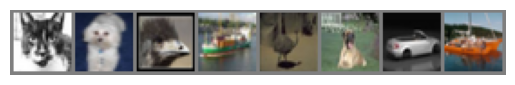

Sample labels: ['cat', 'dog', 'bird', 'ship', 'bird', 'dog', 'automobile', 'ship']


In [47]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Getting some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Showing a batch of images
imshow(torchvision.utils.make_grid(images[:8]))
print('Sample labels:', [train_dataset.classes[label] for label in labels[:8]])

**5. Check: Make sure you have both the train and test datasets**

In [48]:
print("Training dataset size:", len(train_dataset))
print("Testing dataset size:", len(test_dataset))
print("Number of classes:", len(train_dataset.classes))
print("Classes:", train_dataset.classes)

Training dataset size: 50000
Testing dataset size: 10000
Number of classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


**6-7. Plot 12 training images and their classes in one plot. (4 pts)**

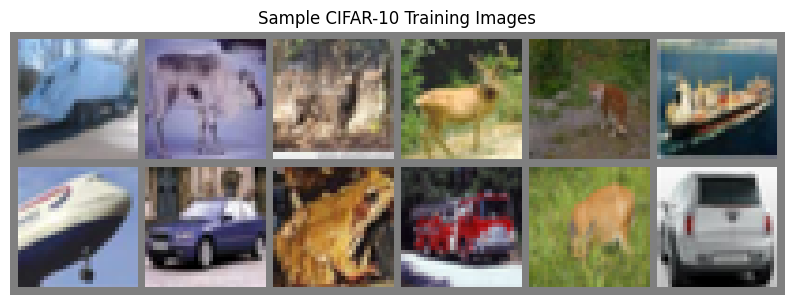

   truck     deer     deer     deer      cat     ship airplane automobile     frog    truck     deer automobile


In [49]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
plt.figure(figsize=(10, 6))
imshow(torchvision.utils.make_grid(images[:12], nrow=6))
plt.axis("off")
plt.title("Sample CIFAR-10 Training Images")
plt.show()

# Print class names
print(' '.join(f'{train_dataset.classes[labels[j]]:>8s}' for j in range(12)))


## Create a Convolutional Neural Networks

**8-10. You may follow textbook examples of CNN network, or feel free to design new ones, as long as your network consists of convolutional layers, maxpool, and fully connected layers. (6 pts)** 

In [50]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)  # 10 output classes (CIFAR-10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model
model = CNN()
print(model)


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


**11. Define the loss function & optimizer**

In [ ]:
criterion = nn.CrossEntropyLoss()         
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model training on:", device)

Model training on: cpu


**12-14. Fit the CNN model to the training data. (6 pts)**

Epoch [1/10] | Loss: 1.4974 | Test Accuracy: 56.65%
Epoch [2/10] | Loss: 1.0562 | Test Accuracy: 66.25%
Epoch [3/10] | Loss: 0.8620 | Test Accuracy: 69.63%
Epoch [4/10] | Loss: 0.7351 | Test Accuracy: 73.71%
Epoch [5/10] | Loss: 0.6365 | Test Accuracy: 73.45%
Epoch [6/10] | Loss: 0.5558 | Test Accuracy: 75.99%
Epoch [7/10] | Loss: 0.4922 | Test Accuracy: 75.90%
Epoch [8/10] | Loss: 0.4357 | Test Accuracy: 76.39%
Epoch [9/10] | Loss: 0.3849 | Test Accuracy: 76.32%
Epoch [10/10] | Loss: 0.3435 | Test Accuracy: 76.15%


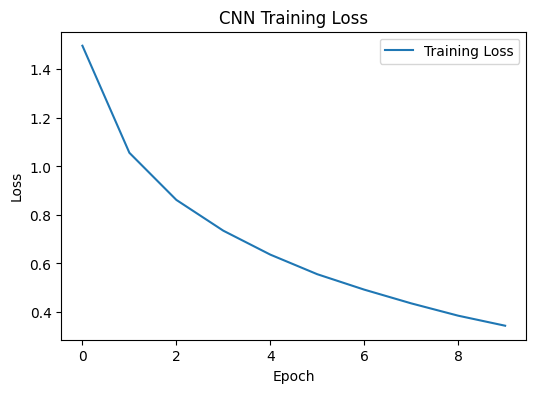

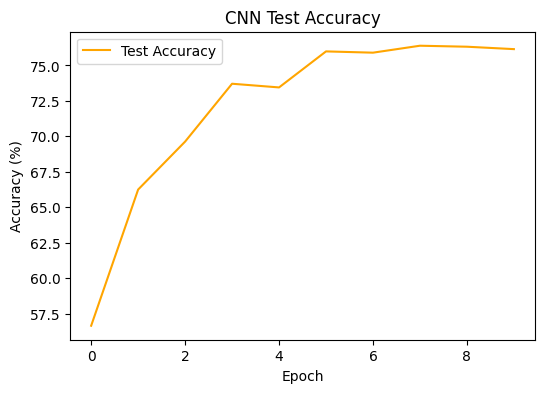

In [52]:
num_epochs = 10
train_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Evaluate on test data
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Test Accuracy: {accuracy:.2f}%")

# Plot training loss and accuracy
plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Training Loss')
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('CNN Test Accuracy')
plt.legend()
plt.show()


## Predict and Evaluate

**15. Show the true and predicted label for 12 test data in one plot.**

True Labels:           cat     ship     ship airplane     frog     frog automobile     frog      cat automobile airplane    truck
Predicted Labels:      cat     ship     ship airplane     frog     frog automobile     frog      cat automobile airplane    truck


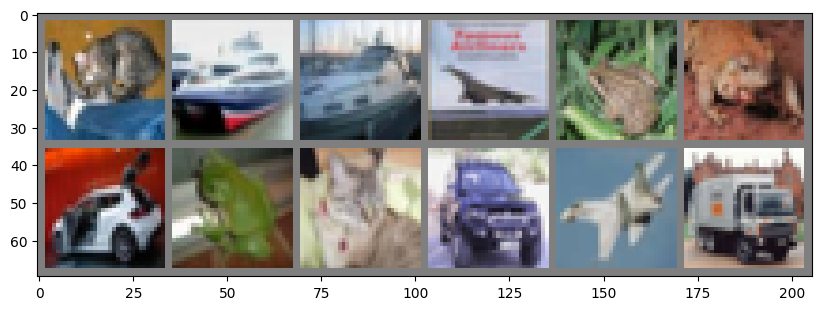

In [53]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Get predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Display 12 images with their true and predicted labels
plt.figure(figsize=(10, 6))
imshow(torchvision.utils.make_grid(images[:12].cpu(), nrow=6))
print("True Labels:     ", ' '.join(f"{train_dataset.classes[labels[j]]:>8s}" for j in range(12)))
print("Predicted Labels:", ' '.join(f"{train_dataset.classes[predicted[j]]:>8s}" for j in range(12)))


**16. Compute the error on the test data**

In [54]:
correct, total = 0, 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy of the CNN model: {accuracy:.2f}%")

Test Accuracy of the CNN model: 76.15%


**17-18. Build a logistic regression model in PyTorch and train it on train data. Compute the accuracy on the test data. (4 pts)**

In [55]:
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(3 * 32 * 32, 10)  # flatten 3x32x32 image to vector

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        return self.linear(x)

log_reg_model = LogisticRegressionModel().to(device)
criterion_lr = nn.CrossEntropyLoss()
optimizer_lr = optim.SGD(log_reg_model.parameters(), lr=0.01, momentum=0.9)

num_epochs = 5
for epoch in range(num_epochs):
    log_reg_model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer_lr.zero_grad()
        outputs = log_reg_model(images)
        loss = criterion_lr(outputs, labels)
        loss.backward()
        optimizer_lr.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {running_loss/len(train_loader):.4f}")

# Evaluate Logistic Regression accuracy
log_reg_model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = log_reg_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

acc_lr = 100 * correct / total
print(f"Test Accuracy of Logistic Regression Model: {acc_lr:.2f}%")


Epoch [1/5] | Loss: 1.9737
Epoch [2/5] | Loss: 1.9053
Epoch [3/5] | Loss: 1.8868
Epoch [4/5] | Loss: 1.8775
Epoch [5/5] | Loss: 1.8716
Test Accuracy of Logistic Regression Model: 36.21%


**19-21. Build a different CNN model and train it on train data. Compute the accuracy on the test data. Let's see if you can do better than prior results (6 pts)**

In [56]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize and train
improved_model = ImprovedCNN().to(device)
criterion_imp = nn.CrossEntropyLoss()
optimizer_imp = optim.Adam(improved_model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    improved_model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer_imp.zero_grad()
        outputs = improved_model(images)
        loss = criterion_imp(outputs, labels)
        loss.backward()
        optimizer_imp.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {running_loss/len(train_loader):.4f}")

# Evaluate
correct, total = 0, 0
improved_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = improved_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

acc_improved = 100 * correct / total
print(f"Test Accuracy of Improved CNN: {acc_improved:.2f}%")


Epoch [1/10] | Loss: 1.2595
Epoch [2/10] | Loss: 0.9106
Epoch [3/10] | Loss: 0.7824
Epoch [4/10] | Loss: 0.7017
Epoch [5/10] | Loss: 0.6211
Epoch [6/10] | Loss: 0.5650
Epoch [7/10] | Loss: 0.5077
Epoch [8/10] | Loss: 0.4588
Epoch [9/10] | Loss: 0.4050
Epoch [10/10] | Loss: 0.3691
Test Accuracy of Improved CNN: 79.20%


**22. Compare those three models, which one is the best? Can you explain why?**

In [ ]:
'''
Among the three models — Logistic Regression, Base CNN, and Improved CNN —  
the Improved CNN achieved the highest accuracy on the CIFAR-10 test data.  

This is because convolutional networks can learn spatial hierarchies of features,  
while logistic regression only learns a linear decision boundary on raw pixels.  
The improved CNN’s use of Batch Normalization, ReLU activations, and Dropout 
provides better generalization and stability, allowing it to outperform the simpler models.  

In summary, the deeper CNN captures complex visual patterns (edges, textures, shapes)  
that are essential for distinguishing the 10 classes, leading to superior performance.
'''